In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to a uniform size
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

# Download dataset (CIFAR-10 example)
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn

class InvertibleConvLayer(nn.Module):
    def __init__(self, in_channels):
        super(InvertibleConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)

    def inverse(self, y):
        # Here you would implement the actual inverse operation
        return self.conv(y)  # Placeholder for inverse operation

class ICN(nn.Module):
    def __init__(self, num_layers, in_channels):
        super(ICN, self).__init__()
        self.layers = nn.ModuleList([InvertibleConvLayer(in_channels) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def inverse(self, y):
        for layer in reversed(self.layers):
            y = layer.inverse(y)
        return y


In [ ]:
import torch.optim as optim

# Instantiate model, optimizer, and loss function
model = ICN(num_layers=5, in_channels=3).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error loss for simplicity

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for images, _ in train_loader:
        images = images.cuda()
            
        optimizer.zero_grad()
        output = model(images)
        
        loss = criterion(output, images)  # Assuming reconstructing input
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.cuda()
            output = model(images)
            val_loss += criterion(output, images).item()

    print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}')


Epoch 1, Training Loss: 0.009793438017368317, Validation Loss: 0.009816671579269466
Epoch 2, Training Loss: 0.007165220566093922, Validation Loss: 0.006002292048874175
Epoch 3, Training Loss: 0.002668702742084861, Validation Loss: 0.0024669591684463865
Epoch 4, Training Loss: 0.0021411925554275513, Validation Loss: 0.001988921218824567
Epoch 5, Training Loss: 0.001885431818664074, Validation Loss: 0.001521603183547972
Epoch 6, Training Loss: 0.0008692426490597427, Validation Loss: 0.0008579007580514499
Epoch 7, Training Loss: 0.0007008789107203484, Validation Loss: 0.0006724689168793262
Epoch 8, Training Loss: 0.000561113643925637, Validation Loss: 0.0005382985087218368
Epoch 9, Training Loss: 0.0004282321024220437, Validation Loss: 0.0004420924394548675
Epoch 10, Training Loss: 0.00037906388752162457, Validation Loss: 0.0003724950519583194
Epoch 11, Training Loss: 0.00033806124702095985, Validation Loss: 0.00032514386315782594
Epoch 12, Training Loss: 0.00025341269792988896, Validatio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.972879..14.507242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.345912..11.991253].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.498028..11.196629].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.855697..11.253397].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.660419..11.714074].


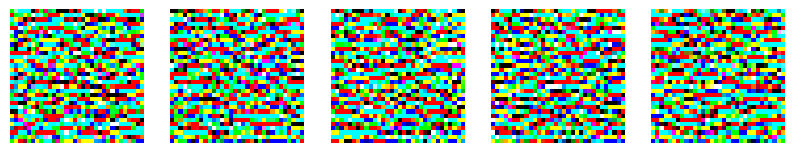

In [19]:
import matplotlib.pyplot as plt

def generate_images(model, num_samples):
    model.eval()
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, 3, 32, 32).cuda()  # Random latent samples
        generated_images = model.inverse(latent_samples)
    return generated_images.cpu()

# Generate and visualize images
num_samples = 5
generated_images = generate_images(model, num_samples)

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow((generated_images[i].permute(1, 2, 0) + 1) / 2)  # Denormalize
    plt.axis('off')
plt.show()
